In [2]:
%%capture
!pip install yfinance

# Managing the Risk of Algorithmic Strategies

In [3]:
import pandas as pd
try:
    import yfinance
    print("module 'yfinance' is installed")
except ModuleNotFoundError:
    print("module 'yfinance' is not installed")
    !pip install yfinance
import yfinance as yf

# Fetch daily data for 4 years
symbol='GOOG'
start_date = '2018-01-01'
end_date = '2021-12-31'

data = yf.download(symbol, start_date, end_date)

module 'yfinance' is installed
[*********************100%***********************]  1 of 1 completed


#  Variables/constants for EMA Calculation:

In [4]:

num_of_periods_fast=10 # Static time period parameter for the fast EMA
lam_fast_old=2.0/(num_of_periods_fast+1) # Static smoothing factor parameter for fast EMA
ema_fast = 0
ema_fast_values = [] # we will hold fast EMA values for visualization purposes

num_of_periods_slow=40 # Static time period parameter for slow EMA
lam_slow_old=2.0/(num_of_periods_slow+1) # Static smoothing factor parameter for slow EMA
ema_slow = 0
ema_slow_values = [] # we will hold slow EMA values for visualization purposes

apo_values = [] # track computed absolute price oscillator value signals

orders = [] # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = [] # Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = [] # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

last_buy_price = 0 # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0 # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0 # Current position of the trading strategy
buy_sum_price_qty = 0 # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0 # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0 # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0 # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0 # Open/Unrealized PnL marked to market
closed_pnl = 0 # Closed/Realized PnL so far

# Volatility adjusted strategy behavior/thresholds

In [5]:
apo_value_for_buy_entry_old = -10 # APO trading signal value below which to enter buy-orders/long-position
apo_value_for_sell_entry_old = 10 # APO trading signal value above which to enter sell-orders/short-position
min_price_move_from_last_trade_old = 10 # Minimum price change since last trade before considering trading again, 
                                    # this is to prevent over-trading at/around same prices
                                    # we may set this as a % of last traded price
num_shares_per_trade = 10 # Number of shares to buy/sell on every trade
min_profit_to_close_old = 10*num_shares_per_trade

# Risk Limits

In [6]:
RISK_LIMIT_WEEKLY_STOP_LOSS = -12000 * 1.5
RISK_LIMIT_MONTHLY_STOP_LOSS = -14000 * 1.5
RISK_LIMIT_MAX_POSITION = 250 * 1.5
RISK_LIMIT_MAX_POSITION_HOLDING_TIME_DAYS = 120 * 1.5
RISK_LIMIT_MAX_TRADE_SIZE = 10 * 1.5
RISK_LIMIT_MAX_TRADED_VOLUME = 4000 * 1.5


In [7]:

import statistics as stats
import math as math

sma_num_of_periods=20 #the number of lookback periods for caculating volatility
price_history=[]


risk_violated = False

traded_volume = 0
current_pos = 0
current_pos_start = 0

close=data['Close']

for close_price in close:
    price_history.append(close_price)
    if len(price_history) > sma_num_of_periods:
        del(price_history[0])

    sma = stats.mean(price_history)
    variance = 0 # variance is square of standard deviation
    for hist_price in price_history:
        variance = variance + ((hist_price - sma) ** 2)
    stdev = math.sqrt(variance / len(price_history))
  
    stdev_factor = stdev/15  #adjust the dependence
    
    if stdev_factor == 0:
        stdev_factor = 1        
    
    lam_fast=lam_fast_old*stdev_factor
    lam_slow=lam_slow_old*stdev_factor
    
    apo_value_for_buy_entry=apo_value_for_buy_entry_old*stdev_factor
    apo_value_for_sell_entry=apo_value_for_sell_entry_old*stdev_factor
 
    min_price_move_from_last_trade=min_price_move_from_last_trade_old*stdev_factor
    
    min_profit_to_close=min_profit_to_close_old/stdev_factor
    
    # Update fast and slow EMA and computes APO trading signal
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = close_price * lam_fast + (1-lam_fast)*ema_fast
        ema_slow = close_price * lam_slow + (1-lam_slow)*ema_slow
        
    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)
    apo = ema_fast - ema_slow
    apo_values.append(apo)

    if num_shares_per_trade > RISK_LIMIT_MAX_TRADE_SIZE:
        print('Risk Violation NUM_SHARES_PER_TRADE',\
              num_shares_per_trade, ' > RISK_LIMIT_MAX_TRADE_SIZE', \
              RISK_LIMIT_MAX_TRADE_SIZE)
        risk_violated = True
        
    if (not risk_violated and
        ((apo > apo_value_for_sell_entry and abs(close_price - last_sell_price) \
      > min_price_move_from_last_trade)
        or (position > 0 and (apo >= 0 or open_pnl > min_profit_to_close)))):
        orders.append(-1) # mark the sell trade
        last_sell_price = close_price
        position -= num_shares_per_trade # reduce position by the size of this trade
        sell_sum_price_qty += (close_price*num_shares_per_trade) 
        sell_sum_qty += num_shares_per_trade
        print( "Sell ", num_shares_per_trade, " @ ", close_price, "Position: ", position )
    elif (not risk_violated and
        ((apo < apo_value_for_buy_entry and abs(close_price - last_buy_price) > min_price_move_from_last_trade) 
        or (position < 0 and (apo <= 0 or open_pnl > min_profit_to_close)))): 
        orders.append(+1) # mark the buy trade
        last_buy_price = close_price
        position += num_shares_per_trade # increase position by the size of this trade
        buy_sum_price_qty += (close_price*num_shares_per_trade) # update the vwap buy-price
        buy_sum_qty += num_shares_per_trade
        print( "Buy ", num_shares_per_trade, " @ ", close_price, "Position: ", position)
    else: # No trade since none of the conditions were met to buy or sell
        orders.append(0)

    positions.append(position)
    
    # flat and starting a new position
    if current_pos == 0:
        if position != 0:
            current_pos = position
            current_pos_start = len(positions)
    # going from long position to flat or short position or
    # going from short position to flat or long position
    elif current_pos * position <= 0:
        current_pos = position
        position_holding_time = len(positions) - current_pos_start
        current_pos_start = len(positions)
          
        if position_holding_time > RISK_LIMIT_MAX_POSITION_HOLDING_TIME_DAYS:
            print('RiskViolation position_holding_time', position_holding_time,\
                    ' > RISK_LIMIT_MAX_POSITION_HOLDING_TIME_DAYS', \
                    RISK_LIMIT_MAX_POSITION_HOLDING_TIME_DAYS)
            risk_violated = True

    if abs(position) > RISK_LIMIT_MAX_POSITION:
        print('RiskViolation position', position,\
                ' > RISK_LIMIT_MAX_POSITION', RISK_LIMIT_MAX_POSITION)
        risk_violated = True
          
    if traded_volume > RISK_LIMIT_MAX_TRADED_VOLUME:
        print('RiskViolation traded_volume', traded_volume,\
                ' > RISK_LIMIT_MAX_TRADED_VOLUME', RISK_LIMIT_MAX_TRADED_VOLUME)
        risk_violated = True
          
    open_pnl = 0
    if position > 0:
        if sell_sum_qty > 0:  
            open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    elif position < 0:
        if buy_sum_qty > 0: 
            open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
    else:
        closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
        buy_sum_price_qty = 0
        buy_sum_qty = 0
        sell_sum_price_qty = 0
        sell_sum_qty = 0
        last_buy_price = 0
        last_sell_price = 0

    print( "OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl) )
    pnls.append(closed_pnl + open_pnl)
    
    if len(pnls) > 5:
        weekly_loss = pnls[-1] - pnls[-6]
        if weekly_loss < RISK_LIMIT_WEEKLY_STOP_LOSS:
            print('RiskViolation weekly_loss', weekly_loss,' < RISK_LIMIT_WEEKLY_STOP_LOSS', RISK_LIMIT_WEEKLY_STOP_LOSS)
            risk_violated = True

    if len(pnls) > 20:
        monthly_loss = pnls[-1] - pnls[-21]
        if monthly_loss < RISK_LIMIT_MONTHLY_STOP_LOSS:
            print('RiskViolation monthly_loss', monthly_loss, ' < RISK_LIMIT_MONTHLY_STOP_LOSS', RISK_LIMIT_MONTHLY_STOP_LOSS)
            risk_violated = True
 
        

OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
OpenPnL:  0  ClosedPnL:  0  TotalPnL:  0
Sell  10  @  1106.93994140625 Position:  -10
OpenPnL:  0.0  ClosedPnL:  0  TotalPnL:  0.0
OpenPnL:  6.79931640625  ClosedPnL:  0  TotalPnL:  6.79931640625
OpenPnL:  43.299560546875  ClosedPnL:  0  TotalPnL:  43.299560546875
OpenPnL:  14.19921875  ClosedPnL:  0  TotalPnL:  14.19921875
Sell  10  @  1122.260009765625 Position:  -20
OpenPnL:  -153.20068359375  ClosedPnL:  0  TotalPnL:  -153.20068359375
OpenPnL:  -143.20068359375  ClosedPnL:  0  TotalPnL:  -143.20068359375
OpenPnL:  -347.60009765625  ClosedPnL:  0  TotalPnL:  -347.60009765625
OpenPnL:  -303.80126953125  ClosedPnL:  0  TotalPnL:  -303.80126953125
Sell  10  @  1137.510009765625 Position:  -30
OpenPnL:  -458.2006835937523  ClosedPnL:  0  TotalPnL:  -458.2006835937523
Sell  10  @  1155.81005859375 Position:  -40
OpenPnL:  -1007.2021484375  ClosedPnL:  0  TotalPnL:  -

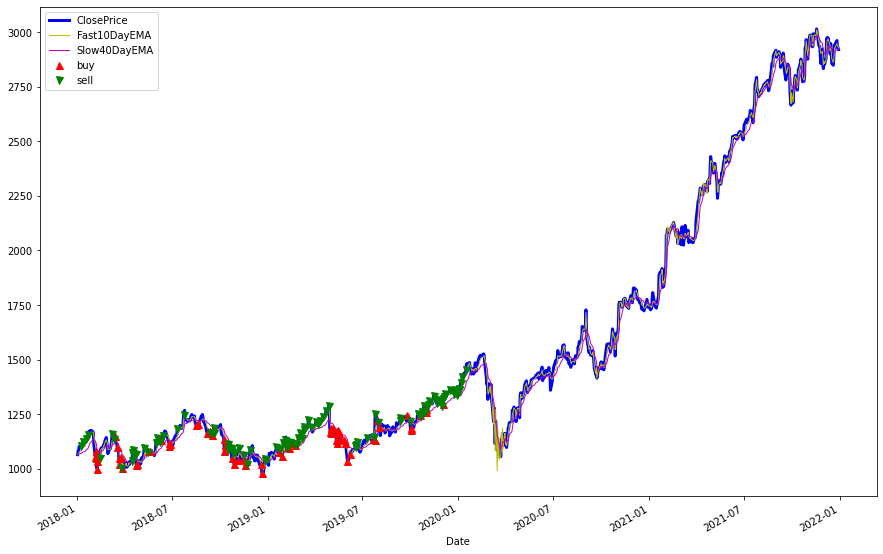

In [8]:
#Prepares the dataframe from the trading strategy results and visualizes the results
data = data.assign(ClosePrice=pd.Series(close, index=data.index))
data = data.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=data.index))
data = data.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=data.index))
data = data.assign(APO=pd.Series(apo_values, index=data.index))
data = data.assign(Trades=pd.Series(orders, index=data.index))
data = data.assign(Position=pd.Series(positions, index=data.index))
data = data.assign(Pnl=pd.Series(pnls, index=data.index))

import matplotlib.pyplot as plt

data['ClosePrice'].plot(color='blue', lw=3., legend=True, figsize=(15,10))
data['Fast10DayEMA'].plot(color='y', lw=1., legend=True, figsize=(15,10))
data['Slow40DayEMA'].plot(color='m', lw=1., legend=True, figsize=(15,10))
plt.plot(data.loc[ data.Trades == 1 ].index, data.ClosePrice[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.ClosePrice[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.savefig('ClosePrice-Fast10DayEMA-Slow40DayEMA-with-vol-adjust.jpg')
plt.show()



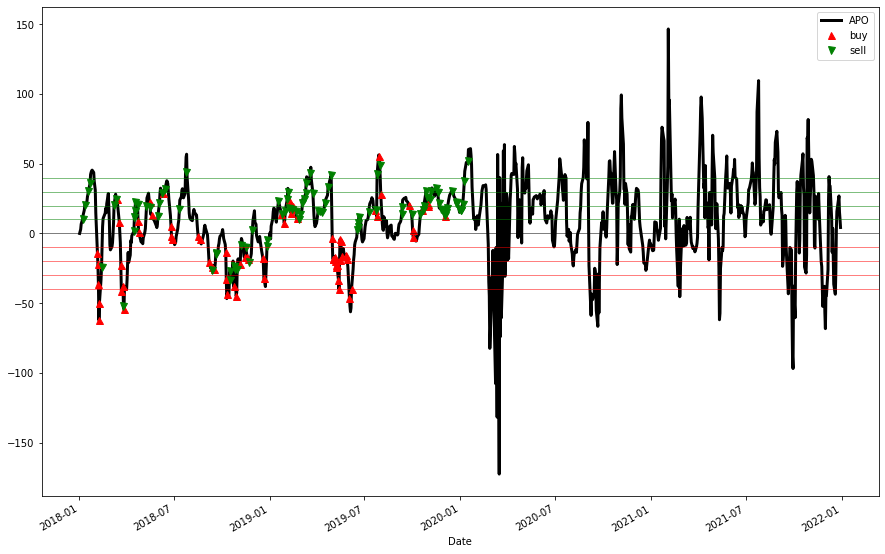

In [9]:
data['APO'].plot(color='k', lw=3., legend=True, figsize=(15,10))
plt.plot(data.loc[ data.Trades == 1 ].index, data.APO[data.Trades == 1 ], \
         color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.APO[data.Trades == -1 ], \
         color='g', lw=0, marker='v', markersize=7, label='sell', )
plt.axhline(y=0, lw=0.5, color='k')
for i in range( apo_value_for_buy_entry_old, apo_value_for_buy_entry_old*5, apo_value_for_buy_entry_old ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( apo_value_for_sell_entry_old, apo_value_for_sell_entry_old*5, apo_value_for_sell_entry_old ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()



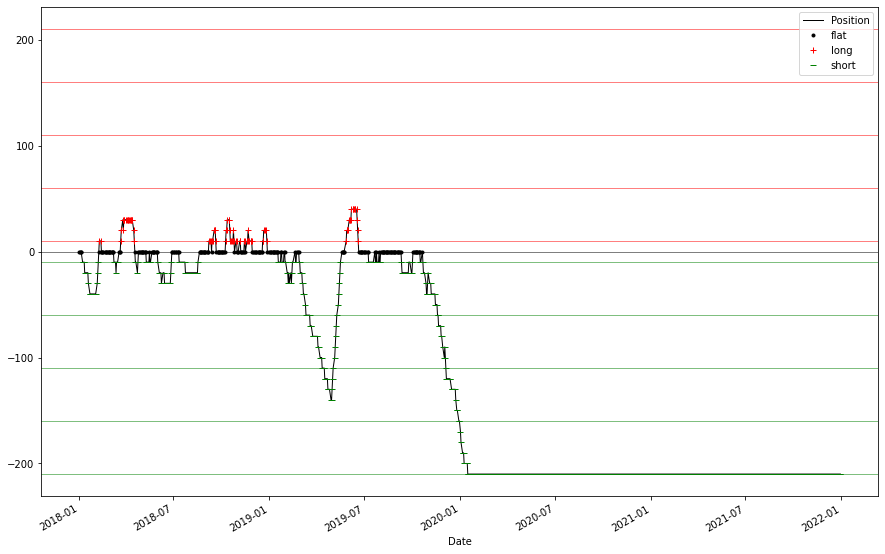

In [10]:
data['Position'].plot(color='k', lw=1., legend=True, figsize=(15,10))
plt.plot(data.loc[ data.Position == 0 ].index, data.Position[ data.Position == 0 ], \
         color='k', lw=0, marker='.', label='flat')
plt.plot(data.loc[ data.Position > 0 ].index, data.Position[ data.Position > 0 ], \
         color='r', lw=0, marker='+', label='long')
plt.plot(data.loc[ data.Position < 0 ].index, data.Position[ data.Position < 0 ], \
         color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( num_shares_per_trade, num_shares_per_trade*25, num_shares_per_trade*5 ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( -num_shares_per_trade, -num_shares_per_trade*25, -num_shares_per_trade*5 ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.savefig('Long-Shot-Position-with-vol-adjust.jpg')
plt.show()



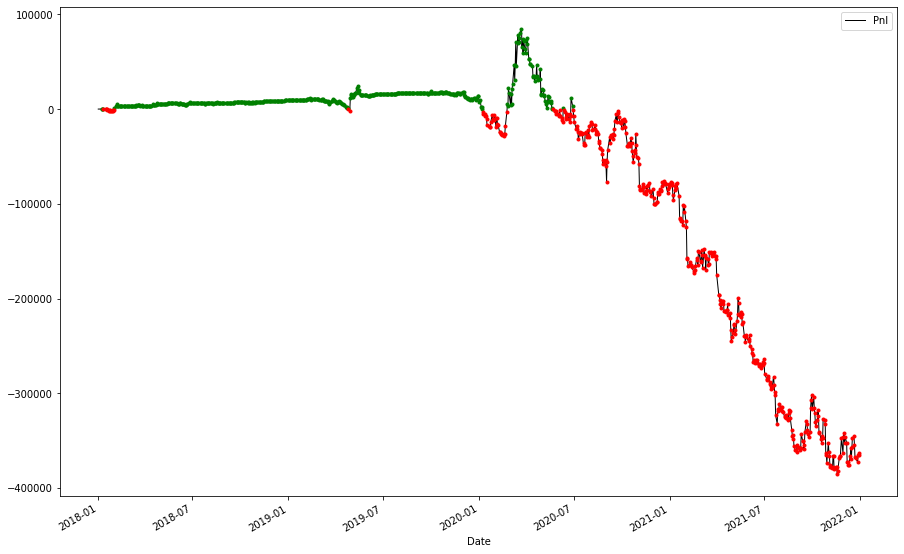

In [11]:

data['Pnl'].plot(color='k', lw=1., legend=True, figsize=(15,10))
plt.plot(data.loc[ data.Pnl > 0 ].index, data.Pnl[ data.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(data.loc[ data.Pnl < 0 ].index, data.Pnl[ data.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.savefig('APO-P&L-with-vol-adjust.jpg')
plt.show()

data.to_csv("mean_reversion-with-vol-adjust.csv", sep=",")